# Olympics Project
Description: In this notebook, we construct a Decision Tree, Random Forest Classifier, Bagging, and Boosting models in attempt to model the data from the Olympics. 
### Authors: Kelvin Wang, Ethan Baird, Arnav Singh, Tuna Akmehmet

In [2]:
#importing data
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data/athlete_events.csv") ## Here we have the raw .csv, feel free to download from Kaggle
print(df.shape)

(271116, 15)


In [3]:
#subsetting
# subset = df[['Sex', 'Age', 'Height', 'Weight', 'NOC', 'Year', 'Sport', 'Event', 'Medal']]
# subset['Medal'].fillna('No Medal', inplace=True)
# 
# 
# #Medal is 0 if they did not get a medal, 1 if they got bronze, silver, or gold
# subset['Medal'] = subset['Medal'].apply(lambda x: 0 if x == 'No Medal' else 1)
# 
# #Sex is 0 if male, 1 if female
# subset['Sex'] = subset['Sex'].apply(lambda x: 0 if x == 'M' else 1)
# 
# subset = subset.dropna()
# 
# subset.shape

###Better way without errors
# Create a subset of the dataframe
subset = df[['Sex', 'Age', 'Height', 'Weight', 'NOC', 'Year', 'Sport', 'Event', 'Medal']].copy()

# Fill missing values in the 'Medal' column
subset['Medal'] = subset['Medal'].fillna('No Medal')

# Convert 'Medal' to 0 if no medal, 1 if any medal
subset['Medal'] = subset['Medal'].apply(lambda x: 0 if x == 'No Medal' else 1)

# Convert 'Sex' to 0 if male, 1 if female
subset['Sex'] = subset['Sex'].apply(lambda x: 0 if x == 'M' else 1)

# Drop rows with any missing values
subset = subset.dropna()

# Display the first few rows of the modified subset, same size as before
subset.shape

(206165, 9)

In [4]:
def reduce_no_medal(df, n):
    '''
    :param df: the dataframe of the athlete events
    :param n: The requested size to reduce the non-medal count too, in order to accurately compare to the medal count.
    :return: the reduced_df with a more accurate size of medals vs. non-medals. We did this because size of non-medals is far greater than with medals
    '''
    no_medals = df[df['Medal'] == 0]
    won_medals = df[df['Medal'] == 1]

    no_medal_sample = no_medals.sample(n=n, random_state=42)

    reduced_df = pd.concat([no_medal_sample, won_medals])

    #shuffle the data, not sure if needed
    reduced_df = reduced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return reduced_df

In [7]:
winners = subset[subset['Medal'] == 1]

# Step 2: Group by Sport/Event and count the occurrences
#sport_counts = medal_1_df['Sport'].value_counts()
sport_counts = winners['Event'].value_counts() # In this case we choose event

# Step 3: Filter to get events/sports with more than 50 entries, in order to get a good sample
sports_with_more_than_50 = sport_counts[sport_counts > 50].index.tolist()

#temp_subset = temp[temp['Sport'].isin(sports_with_more_than_20)]
subset_enough_winners = subset[subset['Event'].isin(sports_with_more_than_50)]

# Display the subset DataFrame
subset_enough_winners.shape

(107065, 9)

In [8]:
#mean_weight_medal_1 = temp[temp['Medal'] == 1].groupby('Sport')['Height'].mean()
mean_weight_medal_1 = subset_enough_winners[subset_enough_winners['Medal'] == 1].groupby('Event')['Weight'].mean()

# Group by Sport and calculate the mean Weight for Medal == 0
#mean_weight_medal_0 = temp[temp['Medal'] == 0].groupby('Sport')['Height'].mean()
mean_weight_medal_0 = subset_enough_winners[subset_enough_winners['Medal'] == 0].groupby('Event')['Weight'].mean()

# Display the results
df1 = mean_weight_medal_1.to_frame(name='Mean_Weight_Medal_1')
df2 = mean_weight_medal_0.to_frame(name='Mean_Weight_Medal_0')

# Merge the two DataFrames on the 'Sport' index
merged_df = pd.merge(df1, df2, left_index=True, right_index=True)

merged_df["diff"] = merged_df["Mean_Weight_Medal_1"] - merged_df["Mean_Weight_Medal_0"]

merged_df.sort_values(by="diff", ascending = True)

,Mean_Weight_Medal_1,Mean_Weight_Medal_0,diff
Event,,,
Gymnastics Men's Floor Exercise,60.941176,63.409057,-2.467880
Gymnastics Men's Individual All-Around,61.176471,63.411201,-2.234731
Gymnastics Men's Team All-Around,61.547945,63.625984,-2.078039
Athletics Men's Pole Vault,74.512658,76.451271,-1.938613
Gymnastics Women's Team All-Around,46.080153,47.711722,-1.631570
...,...,...,...
Basketball Men's Basketball,94.993443,90.673690,4.319753
Swimming Men's 4 x 100 metres Freestyle Relay,84.753769,80.358321,4.395448
Sailing Mixed Two Person Keelboat,90.432099,85.821519,4.610580


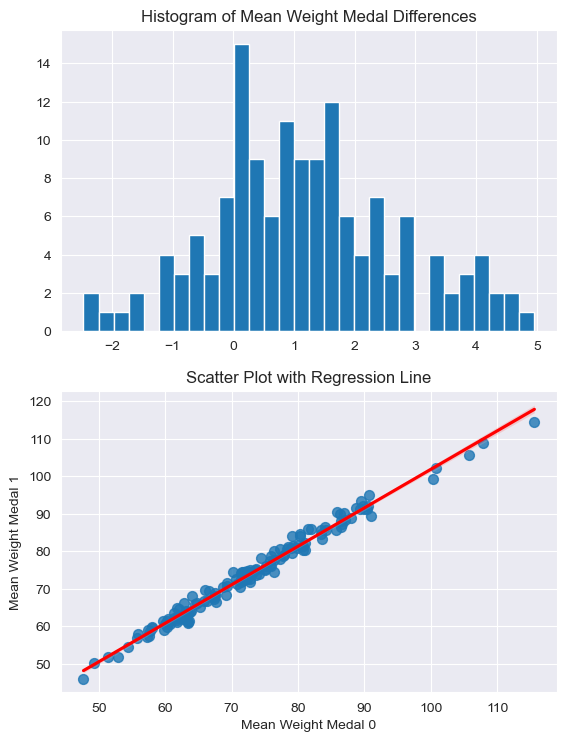

In [9]:
### Plotting this on a graph
plt.subplot(2,1,1)
plt.hist(merged_df["diff"], bins=30)
plt.title("Histogram of Mean Weight Medal Differences")
plt.subplot(2,1,2)
# Use seaborn's regplot to add a scatter plot and regression line
sns.regplot(x='Mean_Weight_Medal_0', y='Mean_Weight_Medal_1', data=merged_df, scatter_kws={'s':50}, line_kws={'color':'red'})

# Add titles and labels
plt.title('Scatter Plot with Regression Line')
plt.xlabel('Mean Weight Medal 0')
plt.ylabel('Mean Weight Medal 1')
plt.subplots_adjust(bottom=-0.5)
plt.show()

In [78]:
# BEGINNING OF UI FOR SELECTION OF SPORT/EVENT
###Creating a UI
import ipywidgets as widgets
from IPython.display import display

final_event = None
model_data = None
button_box = None  # Initialize button_box globally

# Create a dropdown for selecting between "Sport" and "Event"
category_dropdown = widgets.Dropdown(
    options=["Sport", "Event"],
    value="Event",  # Default value
    description='Select Sport/Event:',
    disabled=False,
)

# Function to create buttons based on selected category
def create_buttons(change):
    global model_data, button_box, final_event
    # Clear previous buttons if they exist
    if button_box is not None:
        button_box.children = []
    
    # Get the selected category
    selected_category = category_dropdown.value
    
    if selected_category == "Event":
        # Create a button for each unique event in subset_enough_winners
        unique_events = subset_enough_winners["Event"].unique()
        buttons = [widgets.Button(description=event) for event in unique_events]
        
        # Define what happens when a button is clicked
        def on_event_button_click(b):
            global model_data, final_event
            event = b.description
            model_data = subset_enough_winners[subset_enough_winners["Event"] == event]
            final_event = event
            with output:
                output.clear_output()
                print(f"Selected Event: {event}")
                display(model_data.head())
        
        for button in buttons:
            button.on_click(on_event_button_click)
        
        # Display the buttons
        button_box = widgets.VBox(buttons)
        display(button_box)
    
# Create an output widget to display results
output = widgets.Output()

# Attach the function to the dropdown change event
category_dropdown.observe(create_buttons, names='value')

# Display the widgets in the notebook
display(category_dropdown)
display(output)

# Initial call to create buttons based on the default category
create_buttons(None)
#model_data = subset_enough_winners[subset_enough_winners["Sport"] == "Boxing"]

Dropdown(description='Select Sport/Event:', index=1, options=('Sport', 'Event'), value='Event')

Output()

In [80]:
### Getting rid of Unecessary columns for building the models
model_data = model_data.drop(columns = ["Sport", "Event", "Year"])
# Making sure the size medals vs. non-medals is similar
model_data = reduce_no_medal(model_data, len(model_data[model_data["Medal"] == 1]))

# Creating another model 1-hot encoding the country data
one_hot_model = pd.get_dummies(model_data, columns=['NOC'], dtype = 'int')

# Dropping the NOC column in the original data
model_data = model_data.drop(columns = ["NOC"])

In [81]:
## The model without geographic influence

X = model_data.drop(columns=['Medal'])
Y = model_data['Medal']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state = 42)

basic_data = (X_train, X_test, y_train, y_test)

In [82]:
#one_hot_model = one_hot_model.drop(columns = ["Sport", "Event", "Year"])

### The model with Geographic influence
one_hot_X = one_hot_model.drop(columns=['Medal'])
one_hot_Y = one_hot_model['Medal']

one_hot_X_train, one_hot_X_test, one_hot_y_train, one_hot_y_test = train_test_split(one_hot_X, one_hot_Y, test_size=0.1, random_state = 42)

one_hot_data = (one_hot_X_train, one_hot_X_test, one_hot_y_train, one_hot_y_test)

In [83]:
def model_scorer(model_name, model, data):
    (X_train, X_test, y_train, y_test) = data
    model.fit(X_train, y_train)
    return ((model_name, model.score(X_train, y_train), model.score(X_test, y_test)))

In [84]:
model_scores = []

In [85]:
dtc = DecisionTreeClassifier(max_leaf_nodes = 20)

# Fit model to training data

#dtc.fit(X_train, y_train)
#print("training accuracy: {}| testing accuracy: {}".format(round(dtc.score(X_train, y_train),2), round(dtc.score(X_test, y_test),2)))

#print(export_text(dtc, feature_names = X.columns))
model_scores.append(model_scorer("DTC", dtc, basic_data))

In [86]:
one_hot_dtc = DecisionTreeClassifier(max_leaf_nodes = 20)

# Fit model to training data

#one_hot_dtc.fit(one_hot_X_train, one_hot_y_train)
#print("training accuracy: {}| testing accuracy: {}".format(round(one_hot_dtc.score(one_hot_X_train, one_hot_y_train),2), round(one_hot_dtc.score(one_hot_X_test, one_hot_y_test),2)))

#print(export_text(one_hot_dtc, feature_names = one_hot_X.columns))
model_scores.append(model_scorer("one_hot_DTC", one_hot_dtc, one_hot_data))

In [87]:
#importing sklearn model constructors
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


'''ADD SOME CODE HERE'''
#creating logistic regression model
lg = LogisticRegression(max_iter = 1000)

#saving results
model_scores.append(model_scorer("Logistic", lg, basic_data))

#one hot logistic regression
one_hot_lg = LogisticRegression()

#saving results
model_scores.append(model_scorer("one_hot_Logistic", one_hot_lg, one_hot_data))

/Users/ethanbaird/Desktop/Dartmouth/Math/Math_76/Final_Project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [88]:
#creating LDA model
lda = LinearDiscriminantAnalysis(store_covariance = True)

#saving results
model_scores.append(model_scorer("LDA", lda, basic_data))

#one hot version
one_hot_lda = LinearDiscriminantAnalysis(store_covariance = True)

#saving results
model_scores.append(model_scorer("one_hot_LDA", one_hot_lda, one_hot_data))


In [89]:
#creating random forest model
rfc = RandomForestClassifier()

#saving results
model_scores.append(model_scorer("RFC", rfc, basic_data))

#one hot version
one_hot_rfc = RandomForestClassifier()

#saving results
model_scores.append(model_scorer("one_hot_RFC", one_hot_rfc, one_hot_data))

#creating bagging model
bc = BaggingClassifier()

#saving results
model_scores.append(model_scorer("Bagging", bc, basic_data))

#one hot version
one_hot_bc = BaggingClassifier()

#saving results
model_scores.append(model_scorer("one_hot_Bagging", one_hot_bc, one_hot_data))

#creating boosting model
gbc = GradientBoostingClassifier()

#saving results
model_scores.append(model_scorer("Boosting", gbc, basic_data))

#one hot version
one_hot_gbc = GradientBoostingClassifier()

#saving results
model_scores.append(model_scorer("one_hot_Boosting", one_hot_gbc, one_hot_data))

In [90]:
#creating svc model
svc = SVC()

#saving results
model_scores.append(model_scorer("SVC", svc, basic_data))

#one hot version
one_hot_svc = SVC()

#saving results
model_scores.append(model_scorer("one_hot_SVC", one_hot_svc, one_hot_data))

In [91]:
model_scores = pd.DataFrame(model_scores, columns=['Model', 'Training Accuracy', 'Testing Accuracy'])

In [92]:
model_scores

,Model,Training Accuracy,Testing Accuracy
0,DTC,0.855172,0.529412
1,one_hot_DTC,0.903448,0.647059
2,Logistic,0.613793,0.411765
3,one_hot_Logistic,0.827586,0.588235
4,LDA,0.613793,0.411765
5,one_hot_LDA,0.862069,0.705882
6,RFC,0.993103,0.352941
7,one_hot_RFC,1.000000,0.647059
8,Bagging,0.979310,0.411765
9,one_hot_Bagging,0.986207,0.764706


In [93]:
def model_basic(model, event):
    test_boxing = test_df[test_df['Event']==event].drop(columns=["Year", "Season", "City","Name", "Team","Unnamed: 13", "Event","Sport","NOC","Games"] )
    test_boxing['Sex'] = test_boxing['Sex'].apply(lambda x: 0 if x == 'M' else 1)
    predictions = model.predict(test_boxing)
    return np.array(predictions)

In [94]:
def model_one_hot(model, event):
    test_boxing_one_hot = test_boxing = test_df[test_df['Event']==event].drop(columns=["Year", "Season", "City","Name", "Team","Unnamed: 13", "Event","Sport","Games"] )
    test_boxing_one_hot = pd.get_dummies(test_boxing_one_hot, columns=['NOC'], dtype = 'int')
    list_of_col = list(one_hot_X_train.columns.values)
    for col in list_of_col:
        test_boxing_one_hot[col] = 0

    test_boxing_one_hot = test_boxing_one_hot[one_hot_X_train.columns]

    predictions = model.predict(test_boxing_one_hot)
    return np.array(predictions)

In [95]:
W_Foil_Ind = np.array([1,0,0,0,0,0,0,0,1,1])
M_Div_Spr = np.array([1,1,1,0,0,0,0,0,0])
W_Gym_Floor = np.array([1,1,0,1,0,0,0,0,0])
M_Arch_Ind = np.array([1,0,0,0,1,0,1,0,0,0])
M_Ath_High = np.array([1,1,1,0,0,0,0,0,0,0])
M_Ath_Mara = np.array([1,1,1,0,0,0,0,0,0,0])
M_Box_Heavy = np.array([1,0,1,0,1,0,1,0])
models = [dtc,one_hot_dtc,lg,one_hot_lg,lda,one_hot_lda,rfc,one_hot_rfc,bc,one_hot_bc,gbc,one_hot_gbc,svc,one_hot_svc]
models_names = ["DTC","one_hot_DTC","Logistic","one_hot_Logistic","LDA","one_hot_LDA","RFC","one_hot_RFC","Bagging","one_hot_Bagging","Boosting","one_hot_Boosting","SVC","one_hot_SVC"]
final_acc_list = []
test_df = pd.read_csv("cvs")

i = 0
print(final_event)
for model in models:
    i += 1
    if final_event == "Fencing Women's Foil Individual" or final_event == "Fencing":
        print()
        if i%2 == 0:
            predictions = model_one_hot(model, final_event)
            accuracy = (len(W_Foil_Ind) - np.count_nonzero(predictions - W_Foil_Ind))/len(W_Foil_Ind)
            final_acc_list.append(accuracy)
        else:
            predictions = model_basic(model, final_event)
            accuracy = (len(W_Foil_Ind) - np.count_nonzero(predictions - W_Foil_Ind))/len(W_Foil_Ind)
            final_acc_list.append(accuracy)
    elif final_event == "Boxing Men's Heavyweight" or final_event == "Boxing":
        if i%2 == 0:
            predictions = model_one_hot(model,final_event)
            accuracy = (len(M_Box_Heavy) - np.count_nonzero(predictions - M_Box_Heavy))/len(M_Box_Heavy)
            final_acc_list.append(accuracy)
        else:
            predictions = model_basic(model, final_event)
            accuracy = (len(M_Box_Heavy) - np.count_nonzero(predictions - M_Box_Heavy))/len(M_Box_Heavy)
            final_acc_list.append(accuracy)
    elif final_event == "Diving Men's Springboard" or final_event == "Diving":
        if i%2 == 0:
            predictions = model_one_hot(model,final_event)
            accuracy = (len(M_Div_Spr) - np.count_nonzero(predictions - M_Div_Spr))/len(M_Div_Spr)
            final_acc_list.append(accuracy)
        else:
            predictions = model_basic(model, final_event)
            accuracy = (len(M_Div_Spr) - np.count_nonzero(predictions - M_Div_Spr))/len(M_Div_Spr)
            final_acc_list.append(accuracy)
    elif final_event == "Gymnastics Women's Floor Exercise" or final_event == "Gymnastics":
        if i%2 == 0:
            predictions = model_one_hot(model,final_event)
            accuracy = (len(W_Gym_Floor) - np.count_nonzero(predictions - W_Gym_Floor))/len(W_Gym_Floor)
            final_acc_list.append(accuracy)
        else:
            predictions = model_basic(model, final_event)
            accuracy = (len(W_Gym_Floor) - np.count_nonzero(predictions - W_Gym_Floor))/len(W_Gym_Floor)
            final_acc_list.append(accuracy)
    elif final_event == "Archery Men's Individual" or final_event == "Archery":
        if i%2 == 0:
            predictions = model_one_hot(model,final_event)
            accuracy = (len(M_Arch_Ind) - np.count_nonzero(predictions - M_Arch_Ind))/len(M_Arch_Ind)
            final_acc_list.append(accuracy)
        else:
            predictions = model_basic(model, final_event)
            accuracy = (len(M_Arch_Ind) - np.count_nonzero(predictions - M_Arch_Ind))/len(M_Arch_Ind)
            final_acc_list.append(accuracy)
    elif final_event == "Athletics Men's High Jump":
        if i%2 == 0:
            predictions = model_one_hot(model,final_event)
            accuracy = (len(M_Ath_High) - np.count_nonzero(predictions - M_Ath_High))/len(M_Ath_High)
            final_acc_list.append(accuracy)
        else:
            predictions = model_basic(model, final_event)
            accuracy = (len(M_Ath_High) - np.count_nonzero(predictions - M_Ath_High))/len(M_Ath_High)
            final_acc_list.append(accuracy)
    elif final_event == "Athletics Men's Marathon":
        if i%2 == 0:
            predictions = model_one_hot(model,final_event)
            accuracy = (len(M_Ath_Mara) - np.count_nonzero(predictions - M_Ath_Mara))/len(M_Ath_Mara)
            final_acc_list.append(accuracy)
        else:
            predictions = model_basic(model, final_event)
            accuracy = (len(M_Ath_Mara) - np.count_nonzero(predictions - M_Ath_Mara))/len(M_Ath_Mara)
            final_acc_list.append(accuracy)

print(final_acc_list)



Athletics Men's High Jump
[0.3, 0.7, 0.5, 0.7, 0.5, 0.7, 0.4, 0.7, 0.4, 0.3, 0.6, 0.7, 0.3, 0.7]
